## 1. Important Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## 2. Working with dataframe

##### We have a time panel dataset

##### 2.1 Impoting the dataset

In [6]:
data = pd.read_csv("data.csv")
pd.options.display.float_format = '{:.2f}'.format

##### 2.2 Working with columns

In [7]:
#We drop one column since they have been repeated i.e. metrics 8 is duplicte of metric7
data.drop(["metric8"],axis = 1, inplace= True)
data.rename(columns = {'metric9':'metric8'}, inplace = True)

In [8]:
data['date'] = pd.to_datetime(data['date'])

## 3. Understanding the data

##### 3.1 We see here that  we have in total of 1169 machines

In [9]:
xxxx = pd.DataFrame(data.groupby(['device']).agg(['count']))
print(xxxx)
xxxx.shape

          date failure metric1 metric2 metric3 metric4 metric5 metric6  \
         count   count   count   count   count   count   count   count   
device                                                                   
S1F01085     6       6       6       6       6       6       6       6   
S1F013BB     6       6       6       6       6       6       6       6   
S1F0166B     6       6       6       6       6       6       6       6   
S1F01E6Y    48      48      48      48      48      48      48      48   
S1F01JE0     6       6       6       6       6       6       6       6   
...        ...     ...     ...     ...     ...     ...     ...     ...   
Z1F1VMZB   292     292     292     292     292     292     292     292   
Z1F1VQFY   125     125     125     125     125     125     125     125   
Z1F26YZB    84      84      84      84      84      84      84      84   
Z1F282ZV    84      84      84      84      84      84      84      84   
Z1F2PBHX    83      83      83      83

(1169, 10)

##### 3.2 There are 304 unique dates in the data set.

In [10]:
xxxx = pd.DataFrame(data.groupby(['date']).agg(['count']))
print(xxxx)
xxxx.shape

           device failure metric1 metric2 metric3 metric4 metric5 metric6  \
            count   count   count   count   count   count   count   count   
date                                                                        
2015-01-01   1163    1163    1163    1163    1163    1163    1163    1163   
2015-01-02   1163    1163    1163    1163    1163    1163    1163    1163   
2015-01-03   1163    1163    1163    1163    1163    1163    1163    1163   
2015-01-04   1162    1162    1162    1162    1162    1162    1162    1162   
2015-01-05   1161    1161    1161    1161    1161    1161    1161    1161   
...           ...     ...     ...     ...     ...     ...     ...     ...   
2015-10-27     31      31      31      31      31      31      31      31   
2015-10-29     31      31      31      31      31      31      31      31   
2015-10-30     31      31      31      31      31      31      31      31   
2015-10-31     31      31      31      31      31      31      31      31   

(304, 10)

##### 3.3 Looking for duplicates

In [11]:
xxxx=data
xxxx=xxxx.drop_duplicates(subset=['date','device'])
print(xxxx.shape)
print(data.shape)

#We have 1 duplicate values 

data=data.drop_duplicates(subset=['date','device'])
data.shape

(124493, 11)
(124494, 11)


(124493, 11)

##### 3.4 Looking for null values

In [12]:
data.isnull().sum(axis = 0)
#There are no null values.

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
dtype: int64

##### 3.5 Understanding the dependent variable i.e. Label


##### There are in total of 124493 instances from which there are 124387 for Non-failure and 106 fo failure. Thus for approximately 1173 failures we have 1 Failure. The data is highly imbalanced.

In [13]:
data["failure"].value_counts()

0    124387
1       106
Name: failure, dtype: int64

##### 3.6 Understanding the correlation of the dataframe just for inference.

C:\Users\Siddharth\AppData\Local\Temp\ipykernel_14400\631904655.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)


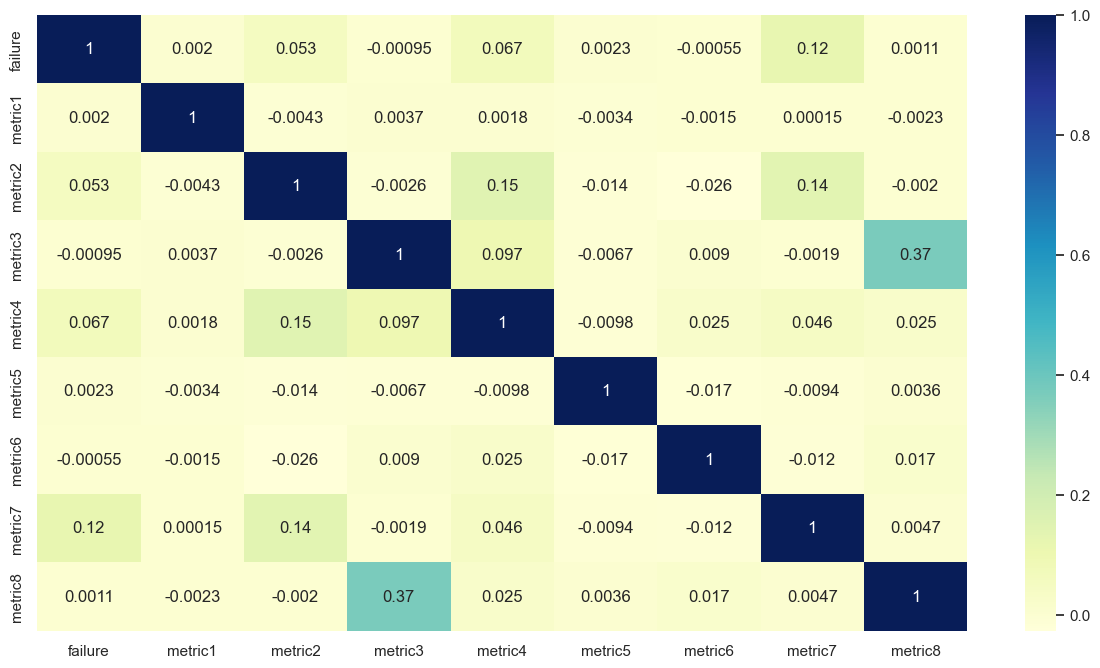

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)


##### Examine the correlation of Dependent Vaiable with Independent Vaiables

In [15]:
corr_matrix = data.corr()
corr_matrix['failure'].sort_values(ascending=False)

C:\Users\Siddharth\AppData\Local\Temp\ipykernel_14400\1385972294.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


failure    1.00
metric7    0.12
metric4    0.07
metric2    0.05
metric5    0.00
metric1    0.00
metric8    0.00
metric6   -0.00
metric3   -0.00
Name: failure, dtype: float64

## 4. Data and Feature Tansformation

##### 4.1 Introducing a flipper column

##### “flipper” indicates when the device changes as the data are sorted by 'device' and 'date' in ascending order. We will use this in a few other transformations.

In [16]:
data=data.sort_values(by=['device','date'], ascending=[True, True])
data['flipper'] = np.where((data.device != data.device.shift(1)), 1, 0)
data.reset_index(inplace = True, drop = True)
data = data[['device','date','failure','metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','flipper']]

In [17]:
data.head(50)

,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,flipper
0,S1F01085,2015-01-01,0,215630672,55,0,52,6,407438,0,7,1
1,S1F01085,2015-01-02,0,1650864,56,0,52,6,407438,0,7,0
2,S1F01085,2015-01-03,0,124017368,56,0,52,6,407438,0,7,0
3,S1F01085,2015-01-04,0,128073224,56,0,52,6,407439,0,7,0
4,S1F01085,2015-01-05,0,97393448,56,0,52,6,408114,0,7,0
5,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,7,0
6,S1F013BB,2015-05-06,0,14533968,0,0,0,5,688952,0,0,1
7,S1F013BB,2015-05-07,0,46202296,0,0,0,5,688952,0,0,0
8,S1F013BB,2015-05-08,0,214383720,0,0,0,5,688964,0,0,0
9,S1F013BB,2015-05-09,0,243346080,0,0,0,5,689035,0,0,0


##### 4.2 Defining a feature window

##### Running summaries are often useful transformations for these types of problems. For example, a running mean would be the average value over the last x days. X, in this case, is the feature window. The feature window is a parameter that depends on the number of observations of a machine over different time. In our case we set it to say: 21


In [18]:
#define your feature window. This is the window by which we will aggregate our sensor values.
feature_window = 5

##### 4.3 Adding additional temporary features to the column.

##### Calculate the number of days from the first day a machine appears in the dataframe to the final day. This field will be called “TIME_SINCE_START” Also, create a variable called “too_soon.” When “too_soon” is equal to 1, we have less than X days of feature_window of history for the machine.
##### We will use these new variables to create a running mean, median, max, and min.

In [19]:
dfx=data

In [20]:
#Select the first record of each machine
starter=dfx[dfx['flipper'] == 1]
starter=starter[['date','device']]

#rename date to start_date
starter=starter.rename(index=str, columns={"date": "start_date"})

#convert START_DATE to datetime format
starter['start_date'] = pd.to_datetime(starter['start_date'])

#Merge START_DATE to the original data set
dfx=dfx.sort_values(by=['device', 'date'], ascending=[True, True])
starter=starter.sort_values(by=['device'], ascending=[True])
dfx =dfx.merge(starter, on=['device'], how='left')

# calculate the number of days since the beginning of each well. 
dfx['temp'] = dfx['date'] - dfx['start_date']

#Converting no. of days to numeric value.
dfx['TIME_SINCE_START'] = dfx['temp'] / np.timedelta64(1, 'D')

#Droping the temp column
dfx=dfx.drop(columns=['temp'])

#Comparing for machine with days less than feature window
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START < feature_window) , 1, 0) #1 = too soon 0 = exceded the time window

dfx.head(50)

,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,flipper,start_date,TIME_SINCE_START,too_soon
0,S1F01085,2015-01-01,0,215630672,55,0,52,6,407438,0,7,1,2015-01-01,0.00,1
1,S1F01085,2015-01-02,0,1650864,56,0,52,6,407438,0,7,0,2015-01-01,1.00,1
2,S1F01085,2015-01-03,0,124017368,56,0,52,6,407438,0,7,0,2015-01-01,2.00,1
3,S1F01085,2015-01-04,0,128073224,56,0,52,6,407439,0,7,0,2015-01-01,3.00,1
4,S1F01085,2015-01-05,0,97393448,56,0,52,6,408114,0,7,0,2015-01-01,4.00,1
5,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,7,0,2015-01-01,5.00,0
6,S1F013BB,2015-05-06,0,14533968,0,0,0,5,688952,0,0,1,2015-05-06,0.00,1
7,S1F013BB,2015-05-07,0,46202296,0,0,0,5,688952,0,0,0,2015-05-06,1.00,1
8,S1F013BB,2015-05-08,0,214383720,0,0,0,5,688964,0,0,0,2015-05-06,2.00,1
9,S1F013BB,2015-05-09,0,243346080,0,0,0,5,689035,0,0,0,2015-05-06,3.00,1


##### 4.4 Feature Transformation/addition

In [21]:
dfx['metric1_mean'] = np.where((dfx.too_soon == 0),(dfx['metric1'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric1)
dfx['metric1_median'] = np.where((dfx.too_soon == 0),(dfx['metric1'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric1)
dfx['metric1_max'] = np.where((dfx.too_soon == 0),(dfx['metric1'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric1)
dfx['metric1_min'] = np.where((dfx.too_soon == 0),(dfx['metric1'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric1)

dfx['metric2_mean'] = np.where((dfx.too_soon == 0),(dfx['metric2'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric2)
dfx['metric2_median'] = np.where((dfx.too_soon == 0),(dfx['metric2'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric2)
dfx['metric2_max'] = np.where((dfx.too_soon == 0),(dfx['metric2'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric2)
dfx['metric2_min'] = np.where((dfx.too_soon == 0),(dfx['metric2'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric2)

dfx['metric3_mean'] = np.where((dfx.too_soon == 0),(dfx['metric3'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric3)
dfx['metric3_median'] = np.where((dfx.too_soon == 0),(dfx['metric3'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric3)
dfx['metric3_max'] = np.where((dfx.too_soon == 0),(dfx['metric3'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric3)
dfx['metric3_min'] = np.where((dfx.too_soon == 0),(dfx['metric3'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric3)

dfx['metric4_mean'] = np.where((dfx.too_soon == 0),(dfx['metric4'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric4)
dfx['metric4_median'] = np.where((dfx.too_soon == 0),(dfx['metric4'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric4)
dfx['metric4_max'] = np.where((dfx.too_soon == 0),(dfx['metric4'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric4)
dfx['metric4_min'] = np.where((dfx.too_soon == 0),(dfx['metric4'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric4)

dfx['metric5_mean'] = np.where((dfx.too_soon == 0),(dfx['metric5'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric5)
dfx['metric5_median'] = np.where((dfx.too_soon == 0),(dfx['metric5'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric5)
dfx['metric5_max'] = np.where((dfx.too_soon == 0),(dfx['metric5'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric5)
dfx['metric5_min'] = np.where((dfx.too_soon == 0),(dfx['metric5'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric5)

dfx['metric6_mean'] = np.where((dfx.too_soon == 0),(dfx['metric6'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric6)
dfx['metric6_median'] = np.where((dfx.too_soon == 0),(dfx['metric6'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric6)
dfx['metric6_max'] = np.where((dfx.too_soon == 0),(dfx['metric6'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric6)
dfx['metric6_min'] = np.where((dfx.too_soon == 0),(dfx['metric6'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric6)

dfx['metric7_mean'] = np.where((dfx.too_soon == 0),(dfx['metric7'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric7)
dfx['metric7_median'] = np.where((dfx.too_soon == 0),(dfx['metric7'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric7)
dfx['metric7_max'] = np.where((dfx.too_soon == 0),(dfx['metric7'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric7)
dfx['metric7_min'] = np.where((dfx.too_soon == 0),(dfx['metric7'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric7)

dfx['metric8_mean'] = np.where((dfx.too_soon == 0),(dfx['metric8'].rolling(min_periods=1, window=feature_window).mean()) , dfx.metric8)
dfx['metric8_median'] = np.where((dfx.too_soon == 0),(dfx['metric8'].rolling(min_periods=1, window=feature_window).median()) , dfx.metric8)
dfx['metric8_max'] = np.where((dfx.too_soon == 0),(dfx['metric8'].rolling(min_periods=1, window=feature_window).max()) , dfx.metric8)
dfx['metric8_min'] = np.where((dfx.too_soon == 0),(dfx['metric8'].rolling(min_periods=1, window=feature_window).min()) , dfx.metric8)

dfx.head(50)

,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,metric6_max,metric6_min,metric7_mean,metric7_median,metric7_max,metric7_min,metric8_mean,metric8_median,metric8_max,metric8_min
0,S1F01085,2015-01-01,0,215630672,55,0,52,6,407438,0,...,407438.00,407438.00,0.00,0.00,0.00,0.00,7.00,7.00,7.00,7.00
1,S1F01085,2015-01-02,0,1650864,56,0,52,6,407438,0,...,407438.00,407438.00,0.00,0.00,0.00,0.00,7.00,7.00,7.00,7.00
2,S1F01085,2015-01-03,0,124017368,56,0,52,6,407438,0,...,407438.00,407438.00,0.00,0.00,0.00,0.00,7.00,7.00,7.00,7.00
3,S1F01085,2015-01-04,0,128073224,56,0,52,6,407439,0,...,407439.00,407439.00,0.00,0.00,0.00,0.00,7.00,7.00,7.00,7.00
4,S1F01085,2015-01-05,0,97393448,56,0,52,6,408114,0,...,408114.00,408114.00,0.00,0.00,0.00,0.00,7.00,7.00,7.00,7.00
5,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,...,409404.00,407438.00,0.00,0.00,0.00,0.00,7.00,7.00,7.00,7.00
6,S1F013BB,2015-05-06,0,14533968,0,0,0,5,688952,0,...,688952.00,688952.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,S1F013BB,2015-05-07,0,46202296,0,0,0,5,688952,0,...,688952.00,688952.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,S1F013BB,2015-05-08,0,214383720,0,0,0,5,688964,0,...,688964.00,688964.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,S1F013BB,2015-05-09,0,243346080,0,0,0,5,689035,0,...,689035.00,689035.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [22]:
temp=dfx[['device','too_soon','TIME_SINCE_START','metric1','metric1_mean']]

In [23]:
temp.head(50)

,device,too_soon,TIME_SINCE_START,metric1,metric1_mean
0,S1F01085,1,0.00,215630672,215630672.00
1,S1F01085,1,1.00,1650864,1650864.00
2,S1F01085,1,2.00,124017368,124017368.00
3,S1F01085,1,3.00,128073224,128073224.00
4,S1F01085,1,4.00,97393448,97393448.00
5,S1F01085,0,5.00,128832128,95993406.40
6,S1F013BB,1,0.00,14533968,14533968.00
7,S1F013BB,1,1.00,46202296,46202296.00
8,S1F013BB,1,2.00,214383720,214383720.00
9,S1F013BB,1,3.00,243346080,243346080.00


##### 4.5 Deviation of sensor values from current values.

In [24]:
dfx['metric1_chg'] = np.where((dfx.metric1_mean == 0),0 , dfx.metric1/dfx.metric1_mean)
dfx['metric2_chg'] = np.where((dfx.metric2_mean == 0),0 , dfx.metric2/dfx.metric2_mean)
dfx['metric3_chg'] = np.where((dfx.metric3_mean==0),0 , dfx.metric3/dfx.metric3_mean)
dfx['metric4_chg'] = np.where((dfx.metric4_mean == 0),0 , dfx.metric4/dfx.metric4_mean)
dfx['metric5_chg'] = np.where((dfx.metric5_mean == 0),0 , dfx.metric5/dfx.metric5_mean)
dfx['metric6_chg'] = np.where((dfx.metric6_mean == 0),0 , dfx.metric6/dfx.metric6_mean)
dfx['metric7_chg'] = np.where((dfx.metric7_mean == 0),0 , dfx.metric7/dfx.metric7_mean)
dfx['metric8_chg'] = np.where((dfx.metric8_mean == 0),0 , dfx.metric8/dfx.metric8_mean)

dfx.head(50)

,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,metric8_max,metric8_min,metric1_chg,metric2_chg,metric3_chg,metric4_chg,metric5_chg,metric6_chg,metric7_chg,metric8_chg
0,S1F01085,2015-01-01,0,215630672,55,0,52,6,407438,0,...,7.00,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00
1,S1F01085,2015-01-02,0,1650864,56,0,52,6,407438,0,...,7.00,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00
2,S1F01085,2015-01-03,0,124017368,56,0,52,6,407438,0,...,7.00,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00
3,S1F01085,2015-01-04,0,128073224,56,0,52,6,407439,0,...,7.00,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00
4,S1F01085,2015-01-05,0,97393448,56,0,52,6,408114,0,...,7.00,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00
5,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,0,...,7.00,7.00,1.34,1.00,0.00,1.00,1.00,1.00,0.00,1.00
6,S1F013BB,2015-05-06,0,14533968,0,0,0,5,688952,0,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
7,S1F013BB,2015-05-07,0,46202296,0,0,0,5,688952,0,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
8,S1F013BB,2015-05-08,0,214383720,0,0,0,5,688964,0,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
9,S1F013BB,2015-05-09,0,243346080,0,0,0,5,689035,0,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


In [25]:
#Making a new datframe
data =dfx

## 5. Dealing with the small number of failures.

##### Because machines generally last a long time, we typically do not have many examples of failure. This means the data sets we use are almost always unbalanced. One way to increase the number of failures is to expand the failure or target window. That is, make the dependent variable, not just the day the equipment failed but the Y days (or another appropriate interval) leading up to the failure.

##### 5.1 Selecting a target window.

##### We take target window as following.

In [26]:
target_window = 10

In [27]:
#Rearanging the dataframe
data=data.sort_values(by=['device', 'date'], ascending=[True, True])
data.reset_index(level=0, inplace=True)

##### 5.2 Create a new data frame that contains the failure records.

In [28]:
#df_failure will contain dates on which a machine has failed
df_failure=data[data['failure'] == 1]
df_failure=df_failure[['date','device']]
print(df_failure)
#Rename DATE to FAILURE_DATE
df_failure=df_failure.rename(index=str, columns={"date": "FAILURE_DATE"})
print(df_failure)

data=data.sort_values(by=['device'], ascending=[True])
df_failure=df_failure.sort_values(by=['device'], ascending=[True])

data =data.merge(df_failure, on=['device'], how='left')
data.head(50)

             date    device
425    2015-01-19  S1F023H2
1048   2015-08-03  S1F03YZM
1715   2015-07-18  S1F09DZQ
3199   2015-01-07  S1F0CTDN
3709   2015-02-14  S1F0DSTY
...           ...       ...
120735 2015-05-12  Z1F1901P
122627 2015-05-08  Z1F1AG5N
123307 2015-01-19  Z1F1FCH5
123824 2015-05-04  Z1F1RJFA
124241 2015-06-30  Z1F1VQFY

[106 rows x 2 columns]
       FAILURE_DATE    device
425      2015-01-19  S1F023H2
1048     2015-08-03  S1F03YZM
1715     2015-07-18  S1F09DZQ
3199     2015-01-07  S1F0CTDN
3709     2015-02-14  S1F0DSTY
...             ...       ...
120735   2015-05-12  Z1F1901P
122627   2015-05-08  Z1F1AG5N
123307   2015-01-19  Z1F1FCH5
123824   2015-05-04  Z1F1RJFA
124241   2015-06-30  Z1F1VQFY

[106 rows x 2 columns]


,index,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,...,metric8_min,metric1_chg,metric2_chg,metric3_chg,metric4_chg,metric5_chg,metric6_chg,metric7_chg,metric8_chg,FAILURE_DATE
0,0,S1F01085,2015-01-01,0,215630672,55,0,52,6,407438,...,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT
1,1,S1F01085,2015-01-02,0,1650864,56,0,52,6,407438,...,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT
2,2,S1F01085,2015-01-03,0,124017368,56,0,52,6,407438,...,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT
3,3,S1F01085,2015-01-04,0,128073224,56,0,52,6,407439,...,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT
4,4,S1F01085,2015-01-05,0,97393448,56,0,52,6,408114,...,7.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT
5,5,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,...,7.00,1.34,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT
6,6,S1F013BB,2015-05-06,0,14533968,0,0,0,5,688952,...,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT
7,7,S1F013BB,2015-05-07,0,46202296,0,0,0,5,688952,...,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT
8,8,S1F013BB,2015-05-08,0,214383720,0,0,0,5,688964,...,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT
9,9,S1F013BB,2015-05-09,0,243346080,0,0,0,5,689035,...,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT


##### 5.3 For each record, calculate the number of days until failure

In [29]:
data=data.sort_values(by=['device','date'], ascending=[True, True])

data['FAILURE_DATE'] = pd.to_datetime(data['FAILURE_DATE'])
data['date'] = pd.to_datetime(data['date'])
data['Temp'] = data['FAILURE_DATE'] - data['date']

data['TIME_TO_FAILURE'] = data['Temp'] / np.timedelta64(1, 'D')

data=data.drop(columns=['index'])
data=data.sort_values(by=['device', 'date'], ascending=[True, True])
data.reset_index(inplace=True)

data.head(50)

,index,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,...,metric2_chg,metric3_chg,metric4_chg,metric5_chg,metric6_chg,metric7_chg,metric8_chg,FAILURE_DATE,Temp,TIME_TO_FAILURE
0,0,S1F01085,2015-01-01,0,215630672,55,0,52,6,407438,...,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT,NaT,NaN
1,1,S1F01085,2015-01-02,0,1650864,56,0,52,6,407438,...,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT,NaT,NaN
2,2,S1F01085,2015-01-03,0,124017368,56,0,52,6,407438,...,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT,NaT,NaN
3,3,S1F01085,2015-01-04,0,128073224,56,0,52,6,407439,...,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT,NaT,NaN
4,4,S1F01085,2015-01-05,0,97393448,56,0,52,6,408114,...,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT,NaT,NaN
5,5,S1F01085,2015-01-06,0,128832128,56,0,52,6,409404,...,1.00,0.00,1.00,1.00,1.00,0.00,1.00,NaT,NaT,NaN
6,6,S1F013BB,2015-05-06,0,14533968,0,0,0,5,688952,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT,NaT,NaN
7,7,S1F013BB,2015-05-07,0,46202296,0,0,0,5,688952,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT,NaT,NaN
8,8,S1F013BB,2015-05-08,0,214383720,0,0,0,5,688964,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT,NaT,NaN
9,9,S1F013BB,2015-05-09,0,243346080,0,0,0,5,689035,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,NaT,NaT,NaN


##### 5.4 Create a new variable, FAILURE_TARGET.

#####  It is equal to 1 if the record proceeds a failure by "failure_window" days or less.

In [30]:
data['FAILURE_TARGET'] = np.where(((data.TIME_TO_FAILURE < target_window) & ((data.TIME_TO_FAILURE>=0))), 1, 0)

In [31]:
data['FAILURE_TARGET'].value_counts()

0    123479
1      1014
Name: FAILURE_TARGET, dtype: int64

## 6. Preparing the dataset

##### 6.1. Get a Unique List of All devices with their wookie number

In [32]:
temp=data
device_id=temp.drop_duplicates(subset='device')
device_id=device_id[['device']]

In [33]:
np.random.seed(42)

##### Assigning values ranging from 0(inclusive) to 1(exclusive) to unique devices

In [34]:
device_id['wookie'] = (np.random.randint(0, 10000, device_id.shape[0]))/10000 
device_id=device_id[['device', 'wookie']]
device_id

,device,wookie
0,S1F01085,0.73
6,S1F013BB,0.09
12,S1F0166B,0.54
18,S1F01E6Y,0.52
66,S1F01JE0,0.57
...,...,...
123825,Z1F1VMZB,0.13
124117,Z1F1VQFY,0.74
124242,Z1F26YZB,0.59
124326,Z1F282ZV,0.13


##### 6.2 Assigning groups to all devices based on their wookie number.

##### Give each record  a 30% chance of being in the testing, and a 70% chance of being in the training data set.

In [35]:
#device_id['MODELING_GROUP'] = np.where(((device_id.wookie <= 0.35)), 'TRAINING', np.where(((device_id.wookie <= 0.65)), 'VALIDATION', 'TESTING'))
device_id['MODELING_GROUP']=np.where((device_id.wookie<=0.70),'TRAINING','TESTING')

##### No of machine falling in each group

In [36]:
device_id['MODELING_GROUP'].value_counts()

TRAINING    837
TESTING     332
Name: MODELING_GROUP, dtype: int64

##### 6.4 Merging data and device_id

In [37]:
data=data.sort_values(by=['device'], ascending=[True])
device_id=device_id.sort_values(by=['device'], ascending=[True])
data =data.merge(device_id, on=['device'], how='inner')

In [38]:
#Distribution of records across dataframe
data['MODELING_GROUP'].value_counts()

TRAINING    88421
TESTING     36072
Name: MODELING_GROUP, dtype: int64

In [39]:
#No of failure records in each set
temp = data.groupby(['MODELING_GROUP'])['FAILURE_TARGET'].sum()
temp

MODELING_GROUP
TESTING     277
TRAINING    737
Name: FAILURE_TARGET, dtype: int32

##### 6.5 Creating seprate dataframes:

In [40]:
#We will use this data set to build the model.
df_training=data[data['MODELING_GROUP'] == 'TRAINING']
df_training=df_training.drop(columns=['MODELING_GROUP','Temp','wookie','TIME_TO_FAILURE','flipper','start_date'])
print(df_training.shape)

#We use this data set to tweak the model
df_train_test=data[data['MODELING_GROUP'] != 'EVERYTHING']
#df_train_test=data[data['MODELING_GROUP'] != 'VALIDATION']
df_train_test=df_train_test.drop(columns=['wookie','TIME_TO_FAILURE','flipper','start_date'])
print(df_train_test.shape)


(88421, 56)
(124493, 58)


## 7. SMOTE the Training Data

##### When we SMOTE the data, we change the failure rate to 50%. This is nowhere near what we see in the actual machine data. Thus, it makes sense to build the model on the SMOTE data but evaluate it on the unaltered data.

##### 7.1 Splitting the dependent and independent variables

In [41]:
training_features = df_training.drop(columns=['index','device','date','failure','TIME_SINCE_START','too_soon','FAILURE_DATE','FAILURE_TARGET'])

In [42]:
training_target=df_training[['FAILURE_TARGET']]

In [43]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 6 to 124492
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   metric1         88421 non-null  int64  
 1   metric2         88421 non-null  int64  
 2   metric3         88421 non-null  int64  
 3   metric4         88421 non-null  int64  
 4   metric5         88421 non-null  int64  
 5   metric6         88421 non-null  int64  
 6   metric7         88421 non-null  int64  
 7   metric8         88421 non-null  int64  
 8   metric1_mean    88421 non-null  float64
 9   metric1_median  88421 non-null  float64
 10  metric1_max     88421 non-null  float64
 11  metric1_min     88421 non-null  float64
 12  metric2_mean    88421 non-null  float64
 13  metric2_median  88421 non-null  float64
 14  metric2_max     88421 non-null  float64
 15  metric2_min     88421 non-null  float64
 16  metric3_mean    88421 non-null  float64
 17  metric3_median  88421 non-null

In [44]:
training_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 6 to 124492
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   FAILURE_TARGET  88421 non-null  int32
dtypes: int32(1)
memory usage: 1.0 MB


##### 7.2 Resampling

In [45]:
smx = SMOTE(random_state=12)
x_res, y_res = smx.fit_resample(training_features, training_target.values.ravel())
df_x=pd.DataFrame(x_res)
df_y=pd.DataFrame(y_res)
df_y.columns = ['FAILURE_TARGET']

In [46]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175368 entries, 0 to 175367
Data columns (total 48 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   metric1         175368 non-null  int64  
 1   metric2         175368 non-null  int64  
 2   metric3         175368 non-null  int64  
 3   metric4         175368 non-null  int64  
 4   metric5         175368 non-null  int64  
 5   metric6         175368 non-null  int64  
 6   metric7         175368 non-null  int64  
 7   metric8         175368 non-null  int64  
 8   metric1_mean    175368 non-null  float64
 9   metric1_median  175368 non-null  float64
 10  metric1_max     175368 non-null  float64
 11  metric1_min     175368 non-null  float64
 12  metric2_mean    175368 non-null  float64
 13  metric2_median  175368 non-null  float64
 14  metric2_max     175368 non-null  float64
 15  metric2_min     175368 non-null  float64
 16  metric3_mean    175368 non-null  float64
 17  metric3_me

In [47]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175368 entries, 0 to 175367
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   FAILURE_TARGET  175368 non-null  int32
dtypes: int32(1)
memory usage: 685.2 KB


##### We now see that we have equal number of Failure_Target

In [48]:
df_y.mean(axis = 0) 

FAILURE_TARGET   0.50
dtype: float64

##### 7.3 Merging the dependent and independent variable after SMOTE

In [49]:
df_balanced = pd.concat([df_y, df_x], axis=1)

In [50]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175368 entries, 0 to 175367
Data columns (total 49 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   FAILURE_TARGET  175368 non-null  int32  
 1   metric1         175368 non-null  int64  
 2   metric2         175368 non-null  int64  
 3   metric3         175368 non-null  int64  
 4   metric4         175368 non-null  int64  
 5   metric5         175368 non-null  int64  
 6   metric6         175368 non-null  int64  
 7   metric7         175368 non-null  int64  
 8   metric8         175368 non-null  int64  
 9   metric1_mean    175368 non-null  float64
 10  metric1_median  175368 non-null  float64
 11  metric1_max     175368 non-null  float64
 12  metric1_min     175368 non-null  float64
 13  metric2_mean    175368 non-null  float64
 14  metric2_median  175368 non-null  float64
 15  metric2_max     175368 non-null  float64
 16  metric2_min     175368 non-null  float64
 17  metric3_me

## 8. Build the model on the balanced training data set

##### 8.1 Seprating features, dependent and independent from balanced training dataframe for model development process

In [51]:
features = [x for x in df_balanced.columns if x not in ['FAILURE_TARGET']]  
dependent=pd.DataFrame(df_balanced['FAILURE_TARGET'])
independent=df_balanced.drop(columns=['FAILURE_TARGET'])

##### 8.2 Parameters for the model

In [52]:
estimator_vals=160
lr_vals = 0.8
md_vals = 12
mcw_vals = 0.5
gamma_vals =.1
subsample_vals = .5
c_bt_vals = 1
reg_lambda_vals = 1
reg_alpha_vals = 1

##### 8.3 Define the model

In [53]:
xgb0 = XGBClassifier(objective = 'binary:logistic',use_label_encoder=False,learning_rate = lr_vals,
n_estimators=estimator_vals,max_depth=md_vals,min_child_weight=mcw_vals,
gamma=gamma_vals,subsample=subsample_vals,colsample_bytree=c_bt_vals,
reg_lambda=reg_lambda_vals,reg_alpha=reg_alpha_vals);

C:\Users\Siddharth\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## 9. Evaluating the model

##### Evaluation Function

In [54]:
import matplotlib.pylab as plt
%matplotlib inline
#evaluate_model(xgb0, independent, dependent,features)
def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['FAILURE_TARGET'], eval_metric='error')
    #alg.fit(train[predictors], target['FAILURE_TARGET'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['FAILURE_TARGET'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['FAILURE_TARGET'], dtrain_predprob))

##### Evaluating on training set

C:\Users\Siddharth\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 1
AUC Score (Balanced): 1.000000


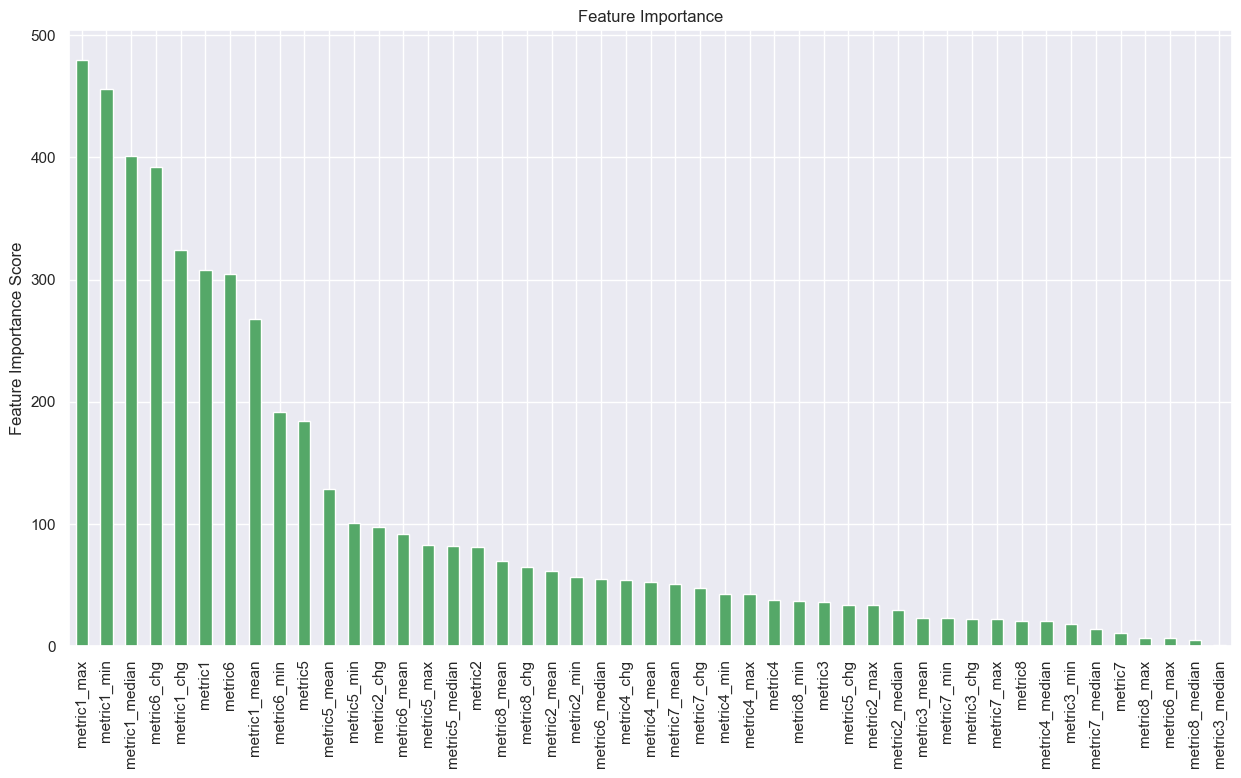

In [55]:
evaluate_model(xgb0, independent, dependent,features) 

##### Evaluation on unbalanced testing data

##### The first step is to split the original data frame into two—one data frame for testing and a second for training.

In [56]:
#Remember df_train_test is the original dataframe without oversampling this dataframe consists of both training as well as testing
df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

##### Now, we will evaluate the unbalanced training data

In [57]:

df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 1
AUC Score (Train): 1.000000


##### Taking a look at the hold-out testing data set. Let's look at the testing data set with a .50 cut-off.

In [58]:
df_testing['P_FAIL']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_FAIL'] = np.where(((df_testing.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FAILURE_TARGET'].values, df_testing['Y_FAIL']))
print("AUC Score (TEST): %f" % metrics.roc_auc_score(df_testing['FAILURE_TARGET'], df_testing['P_FAIL']))

Accuracy : 0.9872
AUC Score (TEST): 0.790830


##### Simple Confusion Matix

In [59]:
print(pd.crosstab(df_testing.Y_FAIL, df_testing.FAILURE_TARGET, dropna=False))
# 1-Device Fails (Postive)
# 0-Device wont fail (Negative)

FAILURE_TARGET      0    1
Y_FAIL                    
0               35564  230
1                 231   47


#####  Thus the TP = 47 ,TN = 35564,FP = 231,FN = 230

##### Matrix with different feature_window and target_window

In [60]:
# feature_window = 10
# target_window = 15
# FAILURE_TARGET      0    1
# Y_FAIL                    
# 0               35347  346
# 1                 315   64

# #END#  